# Example 1 - How to use **Zernike**

In [1]:
import zern.zern_core as zern_core   # import the main library

import logging
import numpy as np
from time import time as tm
from numpy.random import RandomState
import matplotlib.pyplot as plt
plt.rc('font', family='sans-serif')

In [15]:
# Parameters
N = 1024      # Number of pixels
N_zern = 50
rho_max = 1.0
randgen = RandomState(12345)  # random seed
extents = [-rho_max, rho_max, -rho_max, rho_max]

In [3]:
# [0] Construct the coordinates and the aperture mask - simple circ
x = np.linspace(-rho_max, rho_max, N)
xx, yy = np.meshgrid(x, x)
rho = np.sqrt(xx ** 2 + yy ** 2)
theta = np.arctan2(xx, yy)
aperture_mask = rho <= rho_max
rho, theta = rho[aperture_mask], theta[aperture_mask]

## Initializing the Zernike class
The **Zernike** class needs to take the *masked* polar **coordinates** $\rho$ and $\theta$ to calculate the radial polynomials $R_{n,m}$ and the Zernike polynomials $Z_{n,m}$. It also needs to know what **mode** you want to use (we encourage the use of "Jacobi" for numerical stability and not "Standard"). To supress any verbose statements we use ``print_option=None``.

**Zernike** will calculate the maximum number $N_{zern}$ of Zernike polynomials needed based on the shape of the *coefficients* array you provide. 
NOTE: this will be *set* from then on, so choose 

In [4]:
z = zern.Zernike(mask=aperture_mask, log_level=logging.INFO)
_coef = np.zeros(N_zern)
_res = z(coef=_coef, rho=rho, theta=theta, normalize_noll=False, mode='Jacobi', print_option=None)


INFO: Creating Zernike instance



 Mode: Jacobi
Total time required to evaluate 55 Zernike polynomials = 3.520 sec
Average time per polynomials: 64.006 ms


## Using the **model_matrix** to calculate things faster

Once we have initialized the class and called it *once*, **Zernike** will store the *model_matrix* as a property, containing the basis of Zernike polynomials. This means we can speed up the calculation from now on by re-using that matrix and simply performing a *dot* product.

This is done through the *get_zernike* method. This will call the *z.model_matrix* of shape $(p, N_{zern})$, multiply it by the vector of coefficients *coef* of shape $(N_{zern},)$. After that, it will *invert* the flattened result $(p,)$ into a 2D array -> $(N, N)$.

Total time required to evaluate 50 polynomials with dot{H, c} = 0.161 sec


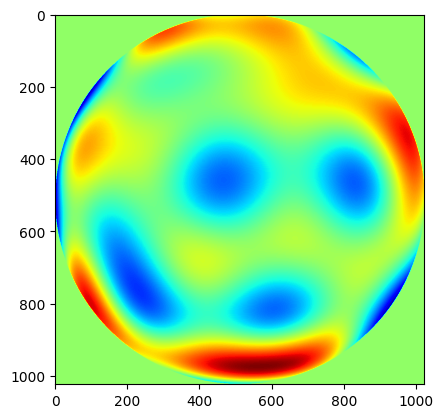

In [5]:
coef = randgen.normal(size=N_zern)
start = tm()
res = z.get_zernike(coef)
speed = tm() - start
print('Total time required to evaluate %d polynomials with dot{H, c} = %.3f sec' % (N_zern, speed))

fig, ax = plt.subplots(1, 1)
ax.imshow(res, cmap='jet')
plt.show()

## Evaluating specific Zernike polynomials $Z_{n,m}$

The **Zernike** class also supports evaluating specific Zernike polynomials based on their $n$ and $m$ orders.

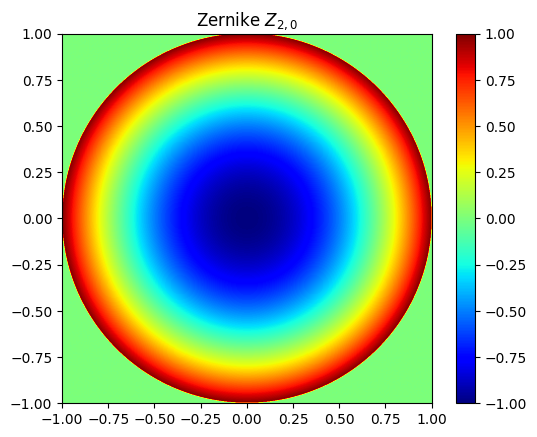

In [23]:
n, m = 2, 0
mode = "Jacobi"

z_flat = z.Z_nm(n, m, rho, theta, False, mode)
z_map = zern.invert_mask(z_flat, z.mask)

fig, ax = plt.subplots(1, 1)
img = ax.imshow(z_map, cmap='jet', extent=extents, vmin=-1, vmax=1)
ax.set_title(r"Zernike $Z_{%d, %d}$" % (n, m))

cbar = plt.colorbar(img)
# img.set_clim(v_min, v_max)
plt.show()

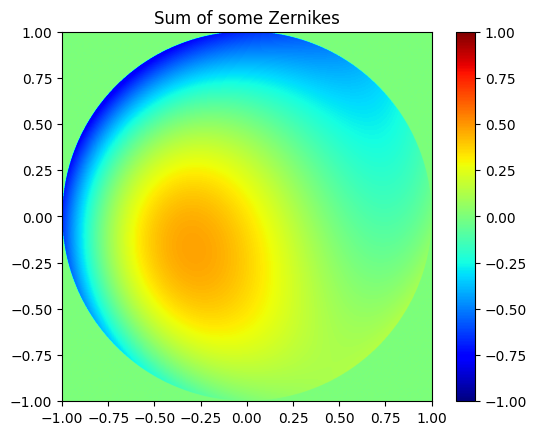

In [31]:
z_11 = z.Z_nm(1, 1, rho, theta, False, mode)
z_31 = z.Z_nm(3, -1, rho, theta, False, mode)
z_20 = z.Z_nm(2, 0, rho, theta, False, mode)
z_tot = (z_11 + z_31 - z_20) / 3
z_map = zern.invert_mask(z_tot, z.mask)

fig, ax = plt.subplots(1, 1)
img = ax.imshow(z_map, cmap='jet', extent=extents, vmin=-1, vmax=1)
ax.set_title(r"Sum of some Zernikes")
cbar = plt.colorbar(img)
plt.show()